# 🧠 Machine Learning for Credit Card Fraud Detection

This notebook documents the machine learning (ML) pipeline applied to the **credit card fraud detection dataset**. It builds on the exploratory data analysis (EDA) and data cleaning steps from the previous notebook, and focuses on building, evaluating, and refining predictive models for this highly imbalanced binary classification problem.

## 🎯 Objectives
1. **Train and evaluate baseline models** to establish reference metrics.
2. **Apply advanced tree-based algorithms (Random Forest, XGBoost)** and tune their hyperparameters to maximize performance.
3. **Handle severe class imbalance** using techniques like `class_weight` adjustments and SMOTE oversampling.
4. **Compare model performance** using metrics suited for imbalanced data (PR AUC, ROC AUC, F1-score).
5. Prepare for the **deep learning stage**, which will complement and expand on these results.

## ⚙️ Dataset Context
The dataset contains credit card transactions, where the target class `Class` indicates fraud (`1`) or legitimate transaction (`0`). All features except `Time` and `Amount` have been PCA-transformed, meaning they are already scaled. In this notebook:
- `Time` is scaled with **MinMaxScaler** (to [0,1]).
- `Amount` is scaled with **RobustScaler** to reduce outlier influence.

---

✅ The workflow in this notebook is structured for clarity, with each model stage documented and visualized to allow LAPES reviewers to follow our design decisions and results.


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_validate,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    RocCurveDisplay,
    confusion_matrix,
    check_scoring
)

from functools import reduce
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib


## 📥 Loading the Silver Dataset and Initial Preprocessing

We start by loading the cleaned dataset from the **Silver layer** of our medallion architecture. The data is split into features (`X`) and target (`y`). We also scale `Time` and `Amount` to ensure all features are on comparable magnitudes.

---

In [2]:
# initial dataframe from the cleaned data in silver layer


silver_path = Path.cwd().parent / 'data' / 'silver' / 'creditcard_fraud_cleaned.parquet'

df = pd.read_parquet(silver_path)
print('the shape of this df should be exactly: (283726, 31)\nshape: ', df.shape)
df.head(3)

the shape of this df should be exactly: (283726, 31)
shape:  (283726, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
# splitting dataset in X(independent features) and y (target class)

X = df.drop(columns='class')
y = df['class']
(y.value_counts()/y.shape[0])*100

class
0    99.83329
1     0.16671
Name: count, dtype: float64

In [4]:
# all the dataset is already scaled with pca transform, except for time and amount
# so after splitting in training and testing the dataset,let's scale:
# time using minMaxscaler, which is standard
# amount using robustScaler, to better treat the significant rigth skewness and outliers


# Dividir os dados em treino, validação e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11037)



In [5]:
# Escalando features para treino efetivo dos modelos
time_scaler = MinMaxScaler()
amount_scaler = RobustScaler()

# fit para escalar os dados de treino
X_train['time_scaled'] = time_scaler.fit_transform(X_train[['time']])
X_train['amount_scaled'] = amount_scaler.fit_transform(X_train[['amount']])

# Transform para impedir data leak
X_test['time_scaled'] = time_scaler.transform(X_test[['time']])
X_test['amount_scaled'] = amount_scaler.transform(X_test[['amount']])

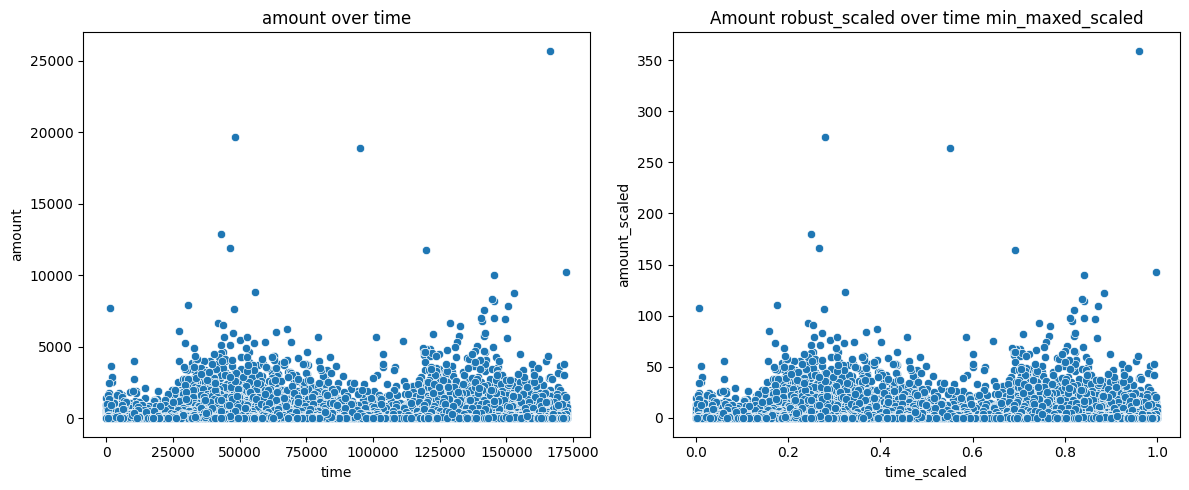

In [6]:
#showing that scalling these features does not lose any information
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# normal time/amount plot
sns.scatterplot(data = X_train, x='time', y='amount', ax=axes[0])
axes[0].set_title('amount over time')

# scaled time/amount plot to show it preserves information
sns.scatterplot(data = X_train, x='time_scaled', y='amount_scaled', ax=axes[1])
axes[1].set_title('Amount robust_scaled over time min_maxed_scaled')


plt.tight_layout()
plt.show()


In [7]:
# preparing the training data (and keeping test data equivalent)
# Retirar colunas não escaladas
X_train = X_train.drop(columns=['time','amount'])
X_test = X_test.drop(columns=['time','amount'])

X_train.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,time_scaled,amount_scaled
236609,-0.393139,1.189324,-0.972845,-1.014526,1.213519,-0.523921,0.791780,0.371723,-0.420744,-1.485694,...,-0.080817,-0.340053,0.140935,0.147952,-1.001315,-0.905524,0.127762,0.205266,0.863844,-0.168054
174231,2.016173,0.090348,-1.915504,1.082426,0.856750,-0.201241,0.423446,-0.104933,0.082016,0.442963,...,0.062826,0.288314,-0.019187,0.272730,0.468915,-0.514713,-0.030063,-0.070282,0.706755,-0.140208
11595,1.396324,-0.481098,0.630109,-0.244255,-1.082479,-0.782327,-0.685069,-0.214074,0.933545,0.138187,...,-0.179179,-0.205599,-0.014325,0.342026,0.514702,-0.280965,-0.016866,0.005586,0.115246,-0.167914


In [8]:
# lets check the data splitting (this could be a function in the ML pipeline) (still simillar proportion)
print('how many frauds and non frauds in the test split\n',y_test.value_counts())
print()
print((y_test.value_counts()/y_test.shape[0])*100)

how many frauds and non frauds in the test split
 class
0    56651
1       95
Name: count, dtype: int64

class
0    99.832587
1     0.167413
Name: count, dtype: float64


## 🧠 Logistic Regression for the Baseline
Logistic Regression is a simple, interpretable model that gives us a **baseline** for detecting fraud.
It's useful for benchmarking because:

- It requires minimal hyperparameter tuning.
- Its coefficients can indicate feature importance.
- However, **Logistic Regression is sensitive to feature scaling**, so we preprocess `time` and `amount`.

---

## ⚠️ Class Imbalance in Fraud Detection
The dataset is **highly imbalanced**:
- Class 0 (Non-Fraud): 99.833%
- Class 1 (Fraud): 0.167%

This means **accuracy** is a **bad metric** (a model predicting "no fraud" every time would still be right 99.8% of the time). Instead, we use metrics that focus on the minority class.

To visually show **why** accuracy is a **bad** metric, it wil always be computed, pay atention to how it barely changes no matter the model

---

## 📏 Key Metrics for Imbalanced Data
| Metric            | Why It Matters                                                        |
|--------------------|------------------------------------------------------------------------|
| **Precision**      | Of all predicted fraud cases, how many were correct?                 |
| **Recall (Sensitivity)** | Of all actual fraud cases, how many did we detect?                  |
| **F1-score**       | Harmonic mean of Precision and Recall (balances false positives and negatives). |
| **ROC AUC**        | Measures model's ability to separate classes across thresholds (also not very relevant in this higly imbalanced case, however it is still a standard metric).      |
| **PR AUC**         | Also called Average Precision, Precision-Recall AUC focuses on the minority class (a **lot** more informative for imbalanced data). |
| **Balanced Accuracy** | Adjusts weights on accuracy to account for class imbalance.                  |

We’ll compute all of these using cross validate and stratified k-fold.

In [9]:
# as this is a binary classification problem (it has two classes, positive, fraud, and negative, non-fraud)
# a logistic classifier is more apropriate

log_clf = LogisticRegression(class_weight='balanced',random_state=11037, max_iter=500)

In [ ]:
# define scorers
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',  
    'recall': 'recall',        
    'f1': 'f1',                
    'roc_auc': 'roc_auc',      
    'pr_auc': 'average_precision',  
    'balanced_accuracy': 'balanced_accuracy',
}

In [ ]:
# define stratified CV to preserve fraud/non-fraud ratio in all folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11037)

In [55]:
# perform cross-validation
cv_results = cross_validate(
    log_clf,
    X_train, y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,

)
results_log_clf_series = pd.DataFrame(cv_results).mean()

In [56]:
results_log_clf_series

fit_time                  1.091593
score_time                0.052265
test_accuracy             0.977738
test_precision            0.064545
test_recall               0.907298
test_f1                   0.120442
test_roc_auc              0.977427
test_pr_auc               0.748303
test_balanced_accuracy    0.942577
dtype: float64

In [54]:
def plot_bar_metrics(score_df: pd.DataFrame, title='placeholder'):
    plt.figure(figsize=(12,6))
    model_scores_barplot = sns.barplot(score_df.loc['accuracy':])


    for patch in model_scores_barplot.patches:
        height = patch.get_height()
        if height > 0:
            model_scores_barplot.annotate(f'{height:.4f}',  # formatting
                (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
                ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center

    plt.title(title)
    plt.show()


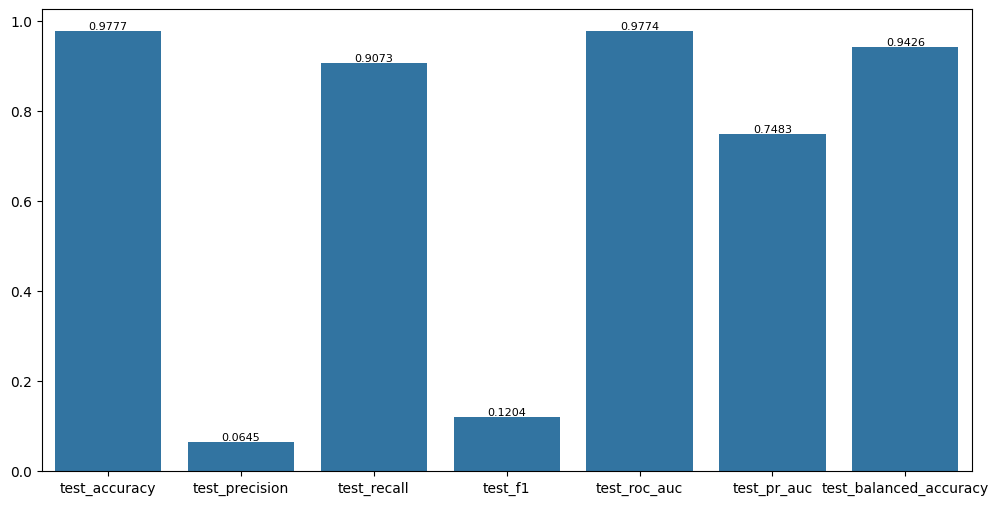

In [ ]:
plot_bar_metrics(results_log_clf_series)

In [15]:
log_clf.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,11037
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


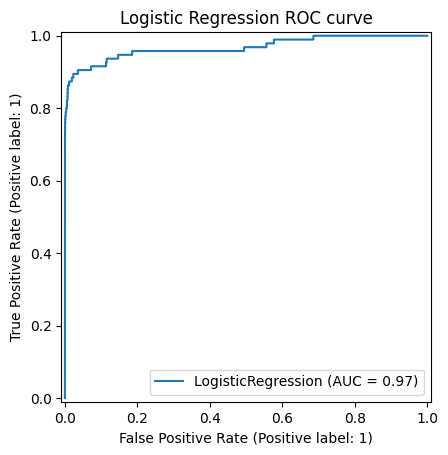

In [16]:
RocCurveDisplay.from_estimator(log_clf, X_test, y_test)
plt.title('Logistic Regression ROC curve')
plt.show()

In [17]:
y_pred_log_clf = log_clf.predict(X_test)

In [19]:
def plot_confusion_matrix( y_pred: pd.DataFrame, y_test: pd.DataFrame, title: str):
    final_model_cm = confusion_matrix(y_test,y_pred)
    labels = ['Fraud', 'Normal']

    sns.heatmap(final_model_cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('predicted class')
    plt.ylabel('actual class')
    print(final_model_cm)

[[55468  1183]
 [   11    84]]


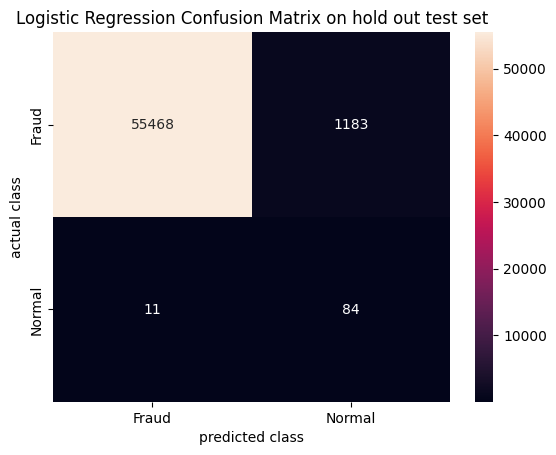

In [20]:
plot_confusion_matrix(y_pred_log_clf, y_test, 'Logistic Regression Confusion Matrix on hold out test set')

In [21]:
# saving the baseline model

file_path = Path.cwd().parent / 'models' / 'logistic_regression_baseline.pkl'
joblib.dump(log_clf, file_path)

print('model succesfully saved in', file_path)

model succesfully saved in e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\models\logistic_regression_baseline.pkl


## Lets  briefly explore the features most correlated to target class (fraud) using the logistic regression model
To do this, we'll check the most correlated features and train a model on all features, starting from the most correlated and adding one each iteration

In [44]:
# 📊 Correlation with target
correlations = X_train.copy()
correlations['target'] = y_train

corr_matrix = abs(correlations.corr())
target_corr = corr_matrix['target'].drop('target').sort_values(ascending=False)

# Display sorted correlations
target_corr


v17              0.320231
v14              0.301369
v12              0.257636
v10              0.210997
v16              0.191054
v3               0.183387
v7               0.172777
v11              0.153448
v4               0.132418
v18              0.108265
v9               0.097115
v1               0.093504
v5               0.087988
v2               0.085986
v6               0.044529
v8               0.035016
v19              0.032730
v21              0.027482
v27              0.025917
v20              0.022778
time_scaled      0.013937
v28              0.012790
v24              0.007786
v23              0.006570
amount_scaled    0.005636
v26              0.005225
v25              0.004712
v13              0.004201
v22              0.004093
v15              0.002831
Name: target, dtype: float64

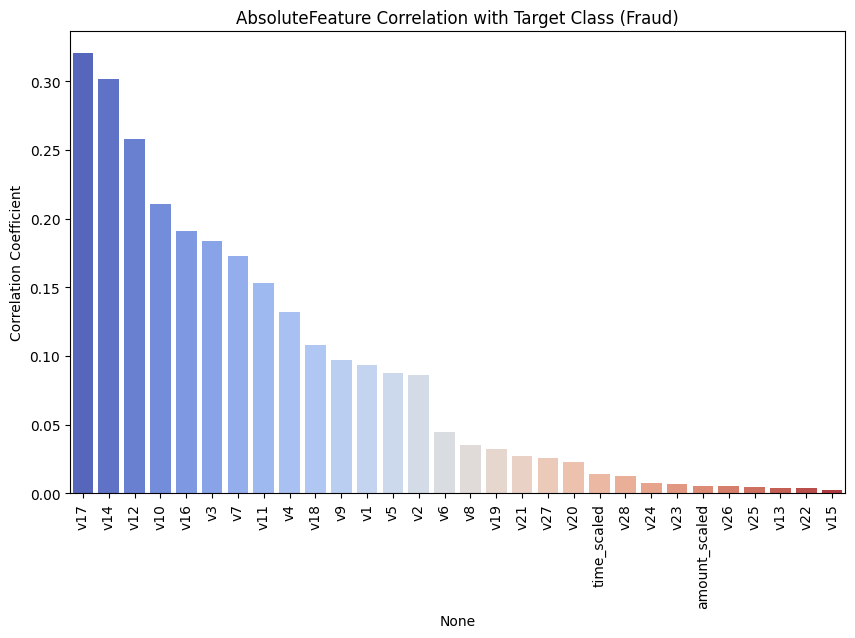

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values,hue=target_corr.index,legend=False, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("AbsoluteFeature Correlation with Target Class (Fraud)")
plt.ylabel("Correlation Coefficient")
plt.show()

In [46]:


used_features = []
scores = []

for f in target_corr.index:
    used_features.append(f)

    log_temp = LogisticRegression(class_weight='balanced', max_iter=400, random_state=11037)

    # 5-fold CV and F1 score (for imbalance)
    cv_scores = cross_val_score(
        log_temp,
        X_train[used_features],
        y_train,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )

    mean_score = cv_scores.mean()
    scores.append(mean_score)

    print(f"Added Feature: {f} | F1-Score: {mean_score:.4f}")


KeyboardInterrupt: 

## 🔍 Forward Feature Selection with Logistic Regression

To explore the contribution of individual features to model performance, we performed a forward feature selection procedure. At each step, we added the next most-correlated feature to the model and computed the mean F1-score using 5-fold cross-validation.

The results show:

- The first feature alone achieves a very high F1-score (~0.65).
- Adding additional features leads to a sharp performance drop and does not improve results significantly.
- This suggests that the first feature captures most of the fraud signal for a linear model like Logistic Regression.

This behavior is expected because:
- Most features are PCA-transformed and orthogonal, meaning they are uncorrelated by construction.
- Logistic Regression may struggle to separate classes in PCA space.

The plot below illustrates this trend.


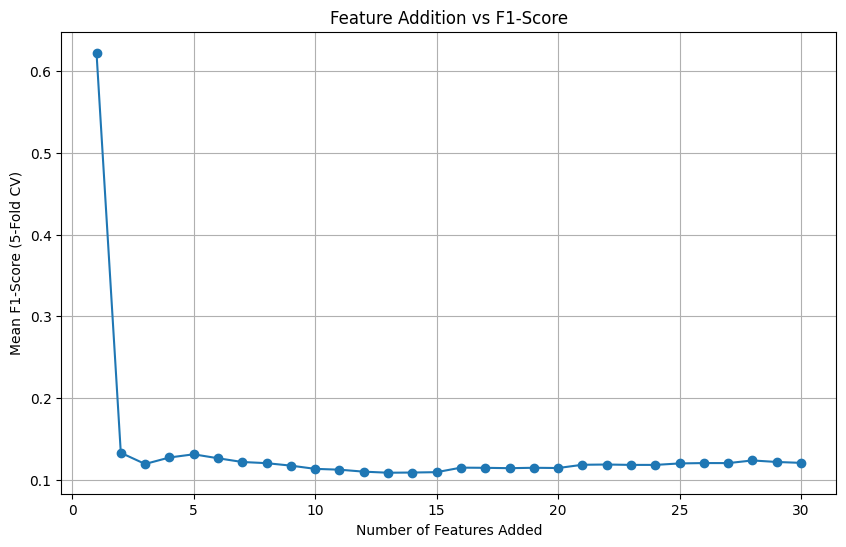

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.title("Feature Addition vs F1-Score")
plt.xlabel("Number of Features Added")
plt.ylabel("Mean F1-Score (5-Fold CV)")
plt.grid(True)
plt.show()

In [26]:
log_v17_clf = LogisticRegression(class_weight='balanced', max_iter=400, random_state=11037)
# perform cross-validation with full metrics on v17 only
cv_v17_results = cross_validate(
    log_v17_clf,
    X_train[['v17']], y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False
)
results_v17_series = pd.DataFrame(cv_v17_results).mean()

In [47]:
def correct_names_after_cv(cv_results_series: pd.Series):
    corrected_names = []
    for index in cv_results_series.index:
        if index.startswith('test_'):
            index = index.removeprefix('test_')
            corrected_names.append(index)
        else:
            corrected_names.append(index)

    cv_results_series.index = corrected_names


In [28]:
correct_names_after_cv(results_v17_series)
results_v17_series

fit_time             0.103509
score_time           0.035217
accuracy             0.998555
precision            0.551049
recall               0.716877
f1                   0.622658
roc_auc              0.803124
pr_auc               0.612341
balanced_accuracy    0.857951
dtype: float64

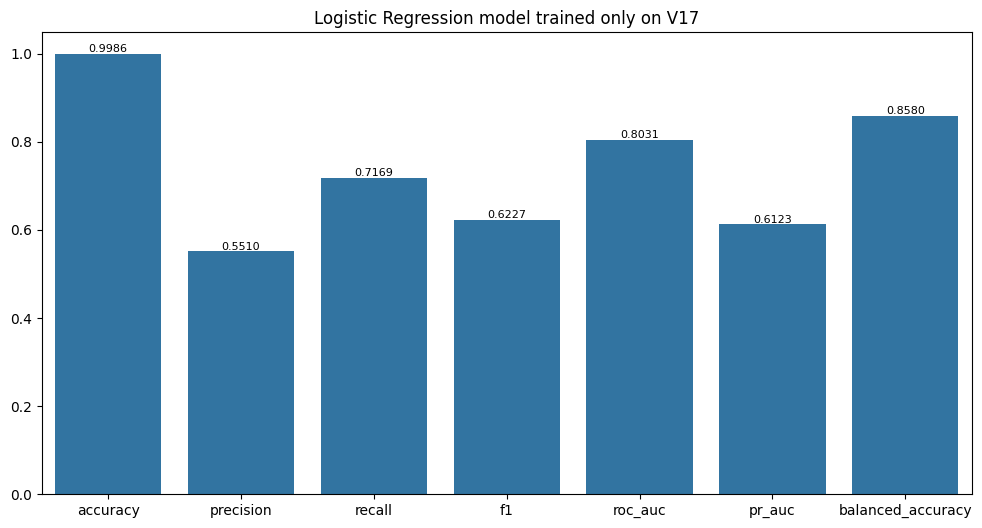

In [ ]:
plot_bar_metrics(results_v17_series, 'Logistic Regression model trained only on V17')

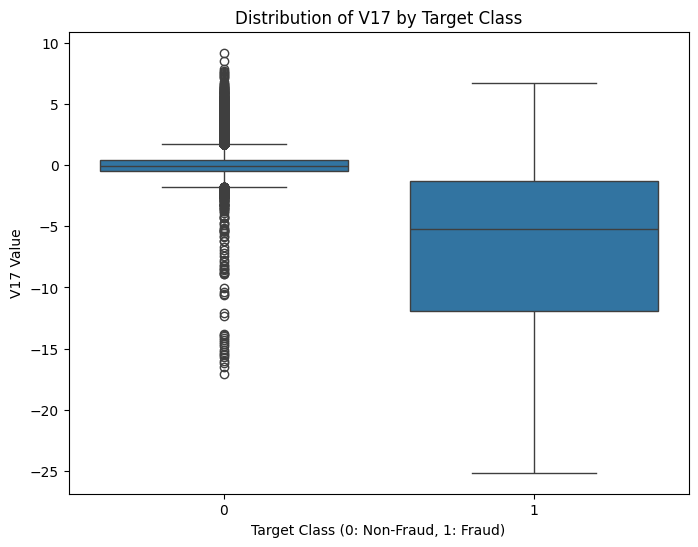

In [30]:


plt.figure(figsize=(8, 6))
sns.boxplot(x=y_train, y=X_train['v17'])
plt.title("Distribution of V17 by Target Class")
plt.xlabel("Target Class (0: Non-Fraud, 1: Fraud)")
plt.ylabel("V17 Value")
plt.show()

## 🚀 Gradient Boosting with XGBoost

We train an **XGBoost model**, leveraging its regularization and built-in handling of imbalanced data (`scale_pos_weight`). Hyperparameters are tuned using **RandomizedSearchCV** for efficiency.

---

In [31]:
# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",  # Binary classification
    eval_metric="aucpr",          # PR AUC for imbalanced data
    scale_pos_weight=10,          # imbalance adjustment
    random_state=11037,
    n_jobs=-1                     # use all cores
)

cv_results = cross_validate(
    xgb_clf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Print mean scores
for metric, scores in cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.4f}")


test_accuracy: 0.9996
test_precision: 0.9347
test_recall: 0.8149
test_f1: 0.8704
test_roc_auc: 0.9791
test_pr_auc: 0.8520
test_balanced_accuracy: 0.9074


In [ ]:
# Parameter grid
param_dist = {
    'n_estimators': [100, 300, 500, 750],
    'max_depth': [3, 6, 10, None],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6,0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 10, 50]  # imbalance adjustment
}

# Randomized Search
xgb_random = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,                # test 20 random combinations
    scoring='average_precision',  # optimize PR AUC, one of the best metrics
    cv=cv,                     
    verbose=1,
    random_state=11037,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train )

print("Best parameters found:", xgb_random.best_params_)
print("Best PR AUC score:", xgb_random.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.7, 'scale_pos_weight': 10, 'n_estimators': 500, 'max_depth': None, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best PR AUC score: 0.8672533748348717


⚠️ **Note on Hyperparameter Boundaries**
When RandomizedSearchCV selects a parameter at the boundary of the search space, it suggests that a better value may lie beyond the current range. To address this, we expanded the grid for that parameter and reran the search, carefully monitoring for overfitting.


In [ ]:
bst_clf = xgb.XGBClassifier(
    **xgb_random.best_params_,
    random_state=11037,
    n_jobs=-1
)

In [34]:
bst_clf = bst_clf.fit(X_train,y_train)

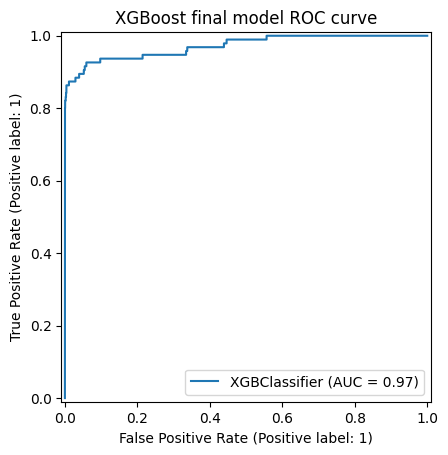

In [35]:
RocCurveDisplay.from_estimator(bst_clf, X_test, y_test)
plt.title('XGBoost final model ROC curve')
plt.show()

[[56644     7]
 [   23    72]]


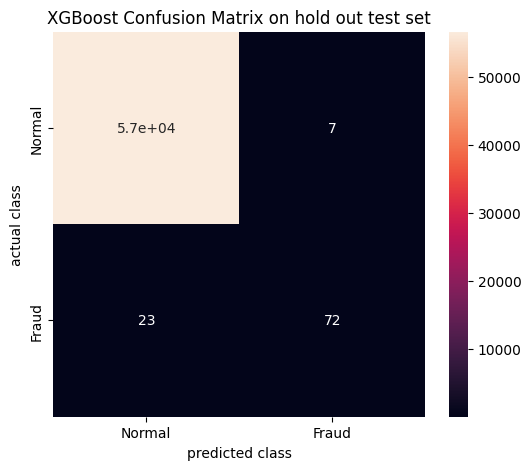

In [36]:
y_pred_bst_clf = bst_clf.predict(X_test)
final_model_cm = confusion_matrix(y_test,y_pred_bst_clf)

# sns.heatmap(final_model_cm,annot=True)


labels = ['Normal', 'Fraud']
plt.figure(figsize=(6, 5))
ax = sns.heatmap(final_model_cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.title('XGBoost Confusion Matrix on hold out test set')
plt.xlabel('predicted class')
plt.ylabel('actual class')
print(final_model_cm)

In [37]:
scoring_call = check_scoring(estimator=bst_clf, scoring=scoring, raise_exc=False)
bst_clf_scores = scoring_call(bst_clf, X_test, y_test)

In [38]:
bst_clf_scores_series = pd.Series(bst_clf_scores)
bst_clf_scores_series

accuracy             0.999471
precision            0.911392
recall               0.757895
f1                   0.827586
roc_auc              0.971707
pr_auc               0.819998
balanced_accuracy    0.878886
dtype: float64

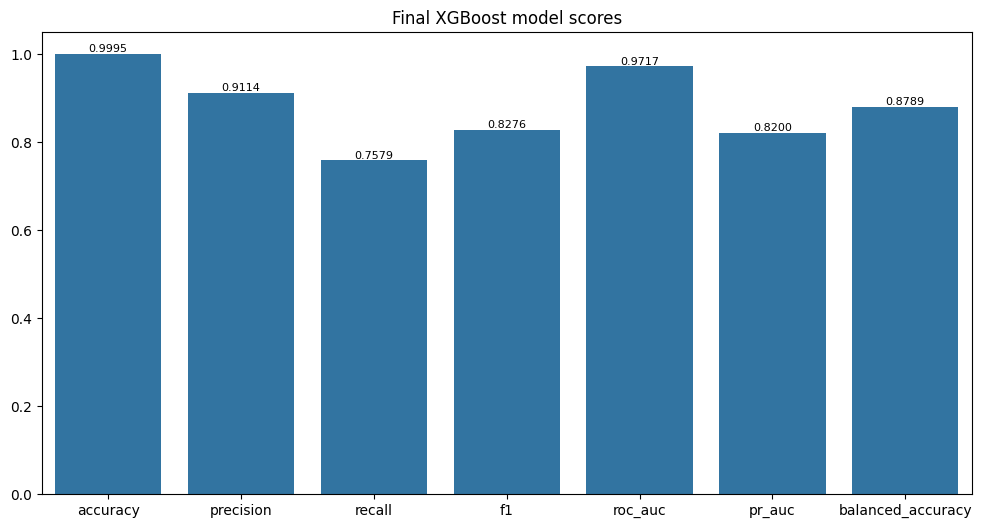

In [39]:
plot_bar_metrics(bst_clf_scores_series,'Final XGBoost model scores')

In [40]:
#saving the XGBoost model
file_path = Path.cwd().parent / 'models' / 'final_XGBoost_model.pkl'
joblib.dump(bst_clf, file_path)

print('model succesfully saved in', file_path)

model succesfully saved in e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\models\final_XGBoost_model.pkl


# 🌲 Random Forest Classifier 

To explore non-linear patterns and potential feature interactions, we train a Random Forest Classifier using all PCA-transformed features and the scaled `Amount` and `Time`.  

Random Forest is a tree-based ensemble method that:  
- Handles imbalanced datasets better than linear models.  
- Provides a direct estimate of feature importances.  

We train the model using 5-fold cross-validation and compute the same evaluation metrics as before.


In [41]:
# ⚙️ Random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',  # Handle class imbalance
    random_state=11037,
    n_jobs=-1
)

# 📊 Evaluate model
rf_cv_results = cross_validate(
    rf_clf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# 📄 Display mean CV scores
for metric, scores in rf_cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.6f}")

results_rand_tree_df = pd.DataFrame(rf_cv_results)


test_accuracy: 0.999515
test_precision: 0.956084
test_recall: 0.743404
test_f1: 0.836314
test_roc_auc: 0.951103
test_pr_auc: 0.847384
test_balanced_accuracy: 0.871673


In [58]:
results_rand_tree_series = pd.DataFrame(rf_cv_results).mean(numeric_only=True)

In [59]:
correct_names_after_cv(results_rand_tree_series)
results_rand_tree_series

fit_time             63.540841
score_time            0.511054
accuracy              0.999515
precision             0.956084
recall                0.743404
f1                    0.836314
roc_auc               0.951103
pr_auc                0.847384
balanced_accuracy     0.871673
dtype: float64

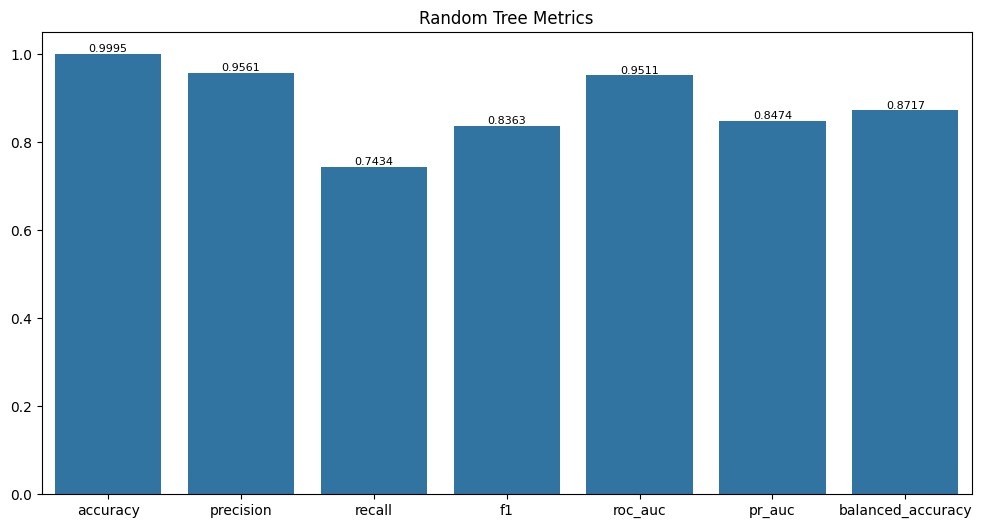

In [60]:
plot_bar_metrics(results_rand_tree_series, 'Random Tree Metrics')

In [61]:
importances = np.mean(
    [estimator.feature_importances_ for estimator in rf_cv_results['estimator']],
    axis=0
)

# 📊 Sort and display
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
feature_importances

v14              0.171445
v10              0.156534
v4               0.133490
v12              0.119032
v11              0.071128
v17              0.054910
v7               0.034041
v3               0.033340
v16              0.031740
v2               0.021371
v21              0.018831
v18              0.014767
amount_scaled    0.012801
v19              0.012717
v8               0.010342
v20              0.009386
v5               0.008728
v9               0.008612
v1               0.008364
v15              0.007450
v13              0.007414
v27              0.007048
v26              0.006782
v28              0.006769
v6               0.006738
v22              0.005675
v23              0.005607
v25              0.005486
v24              0.004851
time_scaled      0.004600
dtype: float64

C:\Users\José Victor\AppData\Local\Temp\ipykernel_10848\1910132794.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")


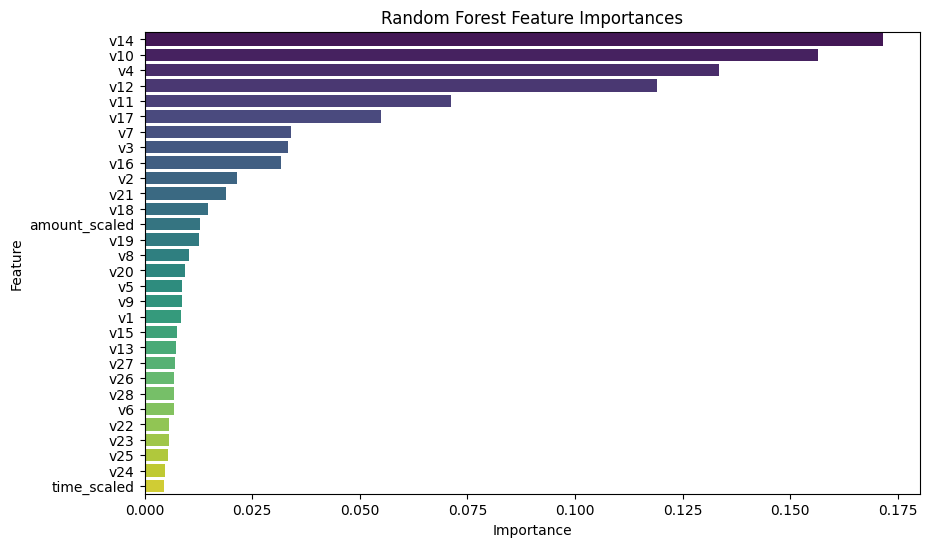

In [62]:
# 📉 Plot Feature Importances


plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## 🌲 Random Forest Feature Importances

The analysis shows that a small subset of PCA-transformed features (notably V14, V10, V4, V12) carries most of the predictive signal for fraud detection. Features like `amount_scaled` have moderate importance, while `time_scaled` and several PCA features contribute little to model performance.

This suggests that fraud is characterized by patterns concentrated in a few principal components. However, Random Forest’s robustness to irrelevant features allows us to retain all features for now.


In [63]:
# lets try to speed training up by limiting training to top 5
features_to_use = feature_importances.index[:5]

In [ ]:
# 📊 Evaluate model
rf_quick_cv_results = cross_validate(
    rf_clf,
    X_train[features_to_use],
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# 📄 Display mean CV scores
for metric, scores in rf_quick_cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.6f}")

results_quick_rand_tree_sample = pd.DataFrame(rf_quick_cv_results)


test_accuracy: 0.999485
test_precision: 0.922460
test_recall: 0.756596
test_f1: 0.830608
test_roc_auc: 0.934276
test_pr_auc: 0.826523
test_balanced_accuracy: 0.878243


In [95]:
results_quick_rand_tree_sample = pd.DataFrame(rf_quick_cv_results)
results_quick_rand_tree_sample

,fit_time,score_time,estimator,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_pr_auc,test_balanced_accuracy
0,27.276737,0.485970,"(DecisionTreeClassifier(max_features='sqrt', r...",0.999537,0.982143,0.733333,0.839695,0.932455,0.837609,0.866656
1,27.251711,0.558108,"(DecisionTreeClassifier(max_features='sqrt', r...",0.999559,0.950820,0.773333,0.852941,0.925704,0.807094,0.886634
2,27.656683,0.113980,"(DecisionTreeClassifier(max_features='sqrt', r...",0.999493,0.934426,0.750000,0.832117,0.933279,0.828931,0.874956
3,23.569543,3.021483,"(DecisionTreeClassifier(max_features='sqrt', r...",0.999317,0.835821,0.736842,0.783217,0.906765,0.757838,0.868300
4,23.982028,2.845763,"(DecisionTreeClassifier(max_features='sqrt', r...",0.999515,0.909091,0.789474,0.845070,0.973177,0.901143,0.894671


In [92]:
correct_names_after_cv(results_quick_rand_tree_sample)
results_quick_rand_tree_sample

fit_time             25.947340
score_time            1.405061
accuracy              0.999485
precision             0.922460
recall                0.756596
f1                    0.830608
roc_auc               0.934276
pr_auc                0.826523
balanced_accuracy     0.878243
dtype: float64

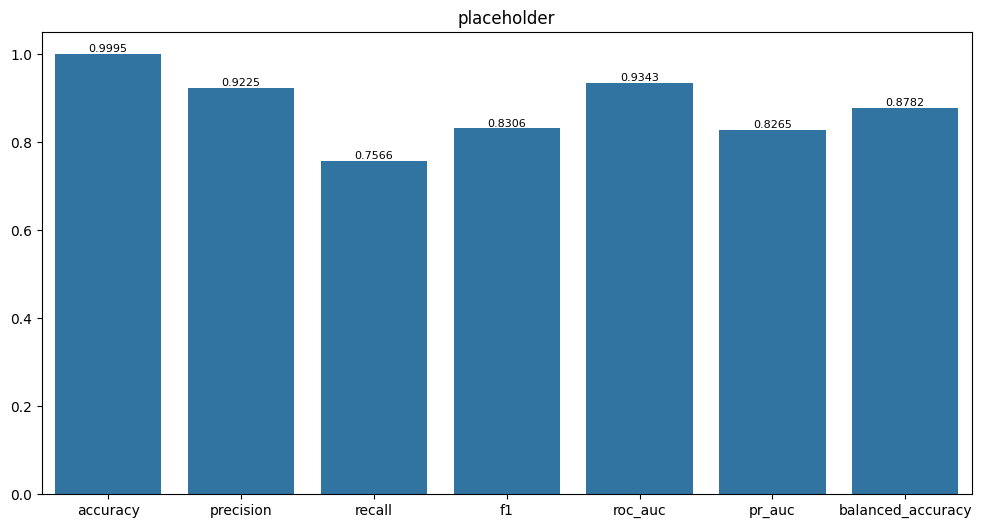

In [93]:
#plotting the quick version
plot_bar_metrics(results_quick_rand_tree_sample)

### 🧿 Hyperparameter tuning with randomized search CV from sklearn


In [68]:


param_dist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", None],
}

rand_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=11037),
    param_distributions=param_dist,
    scoring='average_precision', # pr AUC
    n_iter=10,
    cv=cv,
    random_state=11037,
    n_jobs=-1
)
rand_search.fit(X_train[features_to_use], y_train)


,estimator,RandomForestC...m_state=11037)
,param_distributions,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 300, ...]}"
,n_iter,10
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,11037
,error_score,nan


In [85]:
print("Best parameters:", rand_search.best_params_)
print("F1_score for top model: ", rand_search.best_score_)

Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 30}
F1_score for top model:  0.8287454763862234


In [97]:
tuned_rf_model = RandomForestClassifier(
    **rand_search.best_params_,
    random_state=11037,
    class_weight='balanced',
    n_jobs=-1
)

In [71]:
# eval the model with CV

tuned_rf_cv_results = cross_validate(
    tuned_rf_model,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

tuned_rf_results = pd.DataFrame(tuned_rf_cv_results).mean(numeric_only=True)

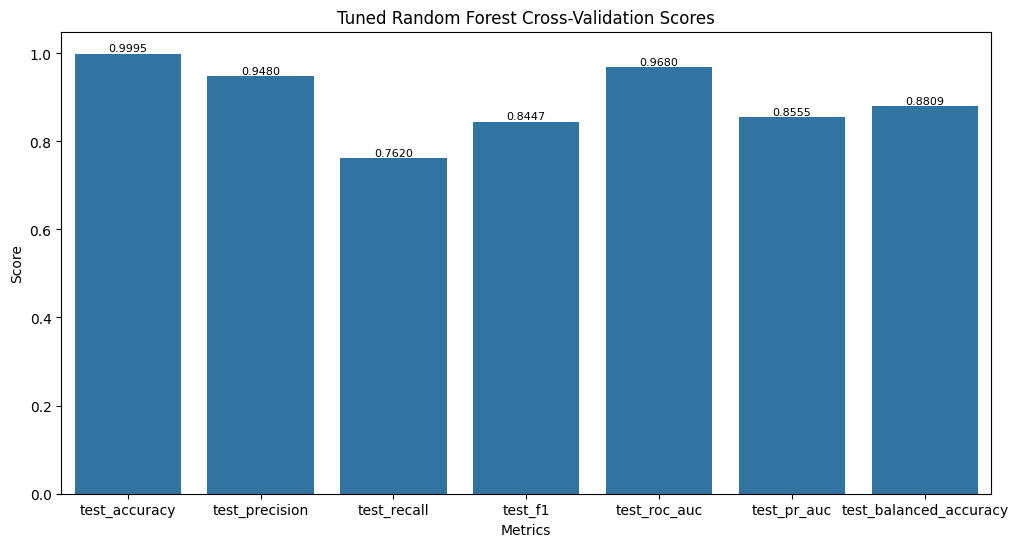

In [72]:
plt.figure(figsize=(12, 6))

# 📊 Bar plot for Random Forest metrics
rf_tuned_scores_barplot = sns.barplot(data=tuned_rf_results.loc['test_accuracy':])

# Annotate bars with their values
for patch in rf_tuned_scores_barplot.patches:
    height = patch.get_height()
    rf_tuned_scores_barplot.annotate(
        f'{height:.4f}',  # Format value
        (patch.get_x() + patch.get_width() / 2, height),  # Center annotation
        ha='center', va='bottom', fontsize=8, color='black'
    )

plt.title("Tuned Random Forest Cross-Validation Scores")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()

### Now that we have found the best hyperparameters, lets train our *final* model on the whole training data

In [73]:
final_rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    max_features='sqrt',
    max_depth=None,
    random_state=11037,
    class_weight='balanced',
    n_jobs=-1,
)

In [74]:
# train the model on the training data
final_rf_model.fit(X_train,y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [75]:
filename = Path.cwd().parent / 'models' / 'final_rf_model.pkl'
final_rf_model = joblib.load(filename=filename)

e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


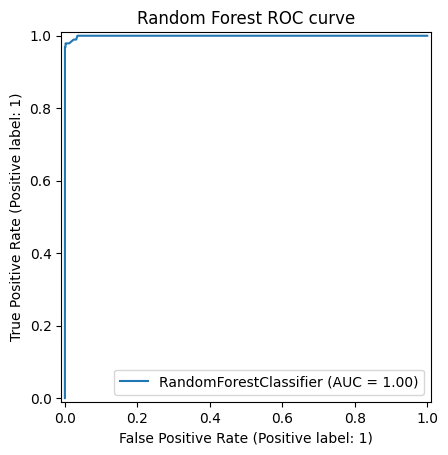

In [76]:
RocCurveDisplay.from_estimator(final_rf_model, X_test, y_test)
plt.title('Random Forest ROC curve')
plt.show()

[[56648     3]
 [    5    90]]


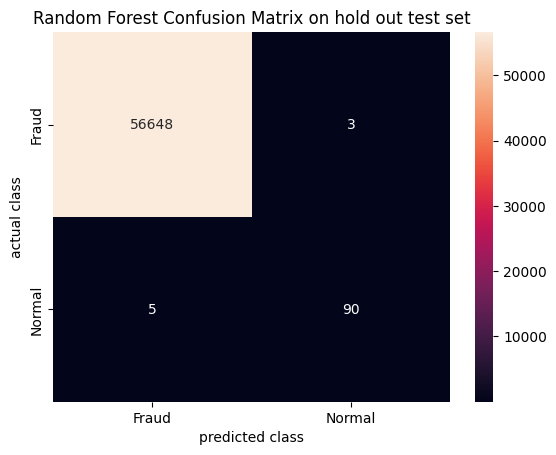

In [77]:
y_pred = final_rf_model.predict(X_test)

plot_confusion_matrix(y_pred, y_test, 'Random Forest Confusion Matrix on hold out test set')

In [78]:
scoring_call = check_scoring(estimator=final_rf_model, scoring=scoring, raise_exc=False)
scores = scoring_call(final_rf_model, X_test, y_test)

In [79]:
scores = pd.Series(scores)

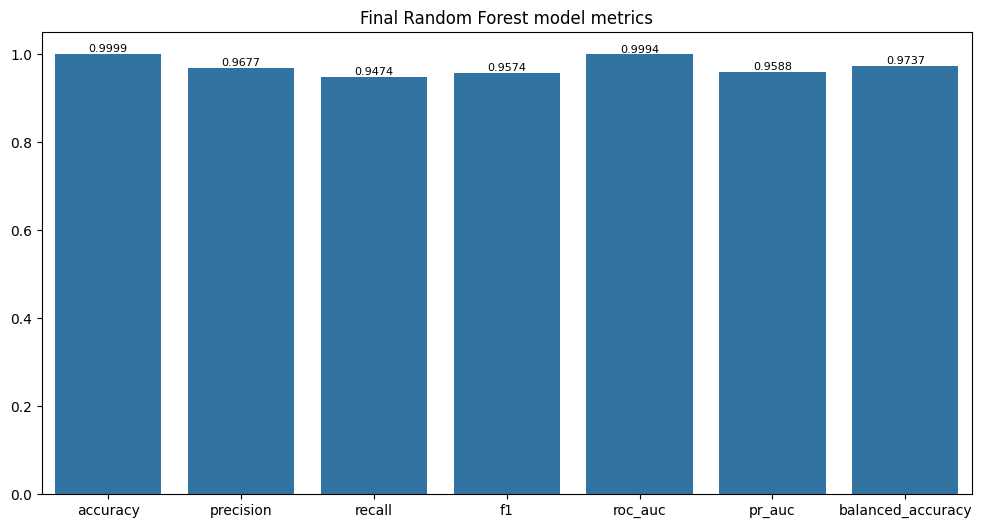

In [80]:
plot_bar_metrics(scores, 'Final Random Forest model metrics')

### finally, saving the final model using joblib

In [81]:
Path.cwd()

WindowsPath('e:/Programacao/LAPES/EDA_ML_DL_PS/LAPES-Data-Challenge-Predictive-Analytics-System/notebooks')

In [82]:

file_path = Path.cwd().parent / 'models' / 'final_rf_model.pkl'
joblib.dump(final_rf_model, file_path)

print('model succesfully saved in', file_path)

model succesfully saved in e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\models\final_rf_model.pkl


In [83]:
filepath_rf = Path.cwd().parent / 'models' / 'final_rf_model.pkl'
filepath_bst = Path.cwd().parent / 'models' / 'final_XGBoost_model.pkl'
filepath_log = Path.cwd().parent / 'models' / 'logistic_regression_baseline.pkl'

log_clf = joblib.load(filepath_log)
bst_clf = joblib.load(filepath_bst)
final_rf_model = joblib.load(filepath_rf)

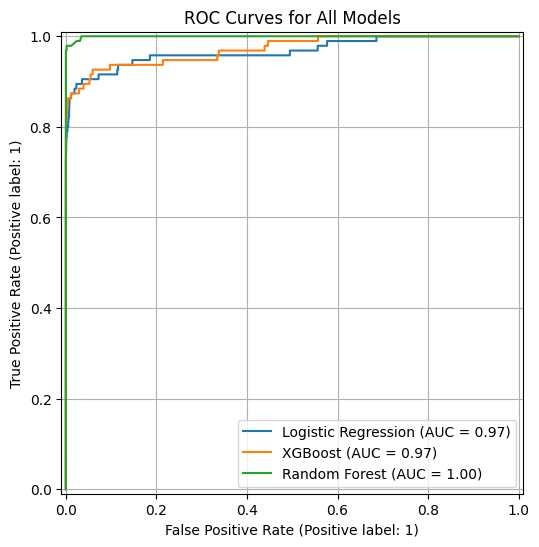

In [84]:
fig, ax = plt.subplots(figsize=(8, 6))


RocCurveDisplay.from_estimator(log_clf, X_test, y_test, ax=ax, name="Logistic Regression")

RocCurveDisplay.from_estimator(bst_clf, X_test, y_test, ax=ax, name="XGBoost")

RocCurveDisplay.from_estimator(final_rf_model, X_test, y_test, ax=ax, name="Random Forest")

ax.set_title("ROC Curves for All Models")
ax.grid(True)

plt.show()
